<a href="https://colab.research.google.com/github/Amirbn73/Air-Pollution-Prediction-PM2.5/blob/main/ANN_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from time import time

In [ ]:
file = files.upload()

Saving test.csv to test.csv


In [ ]:
!git clone https://github.com/PetraVidnerova/rbf_keras.git

Cloning into 'rbf_keras'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 124 (delta 2), reused 3 (delta 0), pack-reused 116
Receiving objects: 100% (124/124), 25.19 KiB | 2.52 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [ ]:
from sklearn.model_selection import KFold
import keras
from keras import layers
import tensorflow
from rbf_keras import kmeans_initializer
from keras.optimizers import RMSprop

In [ ]:
from keras import backend as K
from tensorflow.keras.layers import Layer
from keras.initializers import RandomUniform, Initializer, Constant
import numpy as np


class InitCentersRandom(Initializer):
    """ Initializer for initialization of centers of RBF network
        as random samples from the given data set.

    # Arguments
        X: matrix, dataset to choose the centers from (random rows
          are taken as centers)
    """

    def __init__(self, X):
        self.X = X

    def __call__(self, shape, dtype=None):
      assert shape[1] == self.X.shape[1]
      idx = np.random.randint(self.X.shape[0], size=shape[0])

	# type checking to access elements of data correctly
      if type(self.X) == np.ndarray:
          return self.X[idx, :]
      elif type(self.X) == pd.core.frame.DataFrame:
          return self.X.iloc[idx, :]


class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.

    # Example

    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```


    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas

    """

    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(
                                         value=self.init_betas),
                                     # initializer='ones',
                                     trainable=True)

        super(RBFLayer, self).build(input_shape)

    def call(self, x):

        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-self.betas * K.sum(H**2, axis=1))

        # C = self.centers[np.newaxis, :, :]
        # X = x[:, np.newaxis, :]

        # diffnorm = K.sum((C-X)**2, axis=-1)
        # ret = K.exp( - self.betas * diffnorm)
        # return ret

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
df = pd.read_csv('test.csv')

In [ ]:
ds = pd.read_csv('test.csv')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
ds.head()

,Maximum_Air_Temperature,Minimum_Air_Temperature,Rainfall_Total,Maximum_Gust_Speed,Mean_Wind_Speed,PM2_5,Year,Month,Dis2MR
0,10.008960,4.248512,1.643546,21.813877,8.060351,9.587247,2020,Jan,185.53975
1,10.008616,4.246932,1.643887,21.811733,8.058581,9.588584,2020,Jan,162.24980
2,10.008278,4.245368,1.644224,21.809600,8.056815,9.589995,2020,Jan,142.30249
3,10.007943,4.243823,1.644559,21.807484,8.055056,9.591481,2020,Jan,127.27922
4,10.007614,4.242294,1.644889,21.805378,8.053301,9.593042,2020,Jan,100.62306


In [ ]:
ds.drop(['Year', 'Month'], axis = 1, inplace = True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import keras

In [ ]:
ds.describe()

,Maximum_Air_Temperature,Minimum_Air_Temperature,Rainfall_Total,Maximum_Gust_Speed,Mean_Wind_Speed,PM2_5,Dis2MR
count,4396.000000,4396.000000,4396.000000,4396.000000,4396.000000,4396.000000,4396.000000
mean,10.039108,4.120673,1.676314,21.082102,7.183486,10.119416,588.739974
std,0.027484,0.117704,0.029756,0.661431,0.790813,0.394552,385.967723
min,10.001081,3.884879,1.626037,19.792831,5.650108,9.469854,0.000000
25%,10.014583,4.013679,1.651243,20.460553,6.437649,9.734026,242.332410
50%,10.031526,4.158069,1.667457,21.278478,7.412280,10.133454,541.871770
75%,10.065352,4.216770,1.703790,21.702858,7.934242,10.505697,939.627560
max,10.091137,4.325804,1.734516,21.921993,8.153375,10.680572,1412.311900


In [ ]:
scaler = MinMaxScaler((0,1))
ds['Maximum_Air_Temperature'] = scaler.fit_transform(ds[['Maximum_Air_Temperature']])
ds['Minimum_Air_Temperature'] = scaler.fit_transform(ds[['Minimum_Air_Temperature']])
ds['Rainfall_Total'] = scaler.fit_transform(ds[['Rainfall_Total']])
ds['Maximum_Gust_Speed'] = scaler.fit_transform(ds[['Maximum_Gust_Speed']])
ds['Mean_Wind_Speed'] = scaler.fit_transform(ds[['Mean_Wind_Speed']])
# ds['PM2_5'] = scaler.fit_transform(ds[['PM2_5']])
ds['Dis2MR'] = scaler.fit_transform(ds[['Dis2MR']])

In [ ]:
X = ds.drop('PM2_5',axis = 1)
y = ds[['PM2_5']]

In [ ]:
from sklearn.utils import shuffle

In [ ]:
X_shuffled, y_shuffled = shuffle(X, y, random_state=42)

In [ ]:
print(X_shuffled.shape,y_shuffled.shape)
X_shuffled.head()

(4396, 6) (4396, 1)


,Maximum_Air_Temperature,Minimum_Air_Temperature,Rainfall_Total,Maximum_Gust_Speed,Mean_Wind_Speed,Dis2MR
3942,0.215337,0.923062,0.071158,0.971324,0.976648,0.399238
2658,0.362911,0.610417,0.393263,0.679291,0.685496,0.608735
1532,0.521722,0.463026,0.545159,0.509774,0.513321,0.254901
414,0.723929,0.270012,0.739576,0.292942,0.294032,0.637253
4158,0.273156,0.989361,0.009957,0.996586,0.997361,0.063725


In [ ]:
y_shuffled.head()

,PM2_5
3942,9.507282
2658,10.140871
1532,10.358082
414,10.569426
4158,9.475875


In [ ]:
X_tr, X_test, y_tr, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.1, random_state=42)

In [ ]:
X_test.shape

(440, 6)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.1, random_state=42)

In [ ]:
# kfold = KFold(n_splits = 1)
histories = []
rbfLayer = RBFLayer(10,
                      initializer= kmeans_initializer.InitCentersKMeans(X_shuffled),
                      betas = 2.0,
                      input_shape = ([6]))
ins_model = keras.models.Sequential()
ins_model.add(rbfLayer)
ins_model.add(layers.Dense(1))
ins_model.compile(loss = 'mae',
                    #'mean_squared_error',
                    optimizer = RMSprop())
i = 0
# for train_index, val_index in kfold.split(X_tr):
  # i += 1
  # print(i)
# X_train, X_val = X_tr.iloc[train_index], X_tr.iloc[val_index]
# Y_train, Y_val = y_tr.iloc[train_index], y_tr.iloc[val_index]

  # rbfLayer = RBFLayer(10,
  #                     initializer= kmeans_initializer.InitCentersKMeans(x),
  #                     betas = 2.0,
  #                     input_shape = ([6]))
  # ins_model = keras.models.Sequential()
  # ins_model.add(rbfLayer)
  # ins_model.add(layers.Dense(1))
  # ins_model.compile(loss = 'mae',
  #                   #'mean_squared_error',
  #                   optimizer = RMSprop())
history = ins_model.fit(X_train, y_train,
                          epochs = 500,
                          batch_size = 1024,
                          validation_data = (X_val, y_val)
                          )
histories.append(history)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch 1/500
4/4 [==============================] - 1s 103ms/step - loss: 9.6911 - val_loss: 9.6722
Epoch 2/500
4/4 [==============================] - 0s 21ms/step - loss: 9.6355 - val_loss: 9.6300
Epoch 3/500
4/4 [==============================] - 0s 23ms/step - loss: 9.5952 - val_loss: 9.5937
Epoch 4/500
4/4 [==============================] - 0s 23ms/step - loss: 9.5597 - val_loss: 9.5599
Epoch 5/500
4/4 [==============================] - 0s 15ms/step - loss: 9.5263 - val_loss: 9.5275
Epoch 6/500
4/4 [==============================] - 0s 17ms/step - loss: 9.4941 - val_loss: 9.4959
Epoch 7/500
4/4 [==============================] - 0s 16ms/step - loss: 9.4626 - val_loss: 9.4648
Epoch 8/500
4/4 [==============================] - 0s 17ms/step - loss: 9.4316 - val_loss: 9.4339
Epoch 9/500
4/4 [==============================] - 0s 17ms/step - loss: 9.4009 - val_loss: 9.4032
Epoch 10/500
4/4 [==============================] - 0s 16ms/step - loss: 9.3703 - val_loss: 9.3725
Epoch 11/500
4/4 [

In [ ]:
y_pred = ins_model.predict(X_test,
                           batch_size = 2048)
r2_score(y_test, y_pred)

1/1 [==============================] - 0s 107ms/step


0.7954315647108059

In [ ]:
mean_squared_error(y_test, y_pred)

0.0297356176632832

In [ ]:
mean_absolute_error(y_test, y_pred)

0.12018246672252306

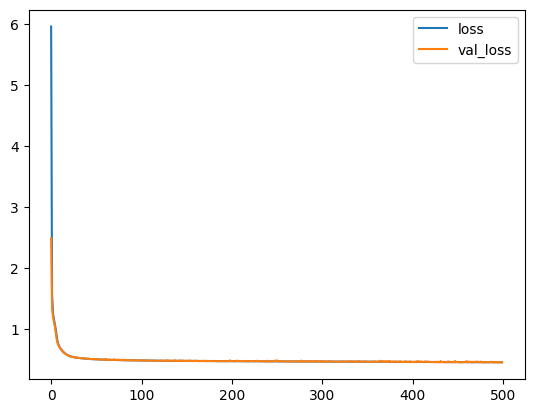

In [ ]:
for i in histories:
  pd.DataFrame(i.history).plot()

In [ ]:
X_test

,Maximum_Air_Temperature,Minimum_Air_Temperature,Rainfall_Total,Maximum_Gust_Speed,Mean_Wind_Speed,Dis2MR
942058,0.513955,0.417793,0.526325,0.478771,0.401374,0.320216
375706,0.888716,0.816276,0.218165,0.295653,0.323228,0.031863
103605,0.219828,0.207240,0.665948,0.880408,0.689427,0.242659
611113,0.317903,0.322402,0.271289,0.232336,0.226781,0.045061
1097675,0.778050,0.819146,0.297395,0.132771,0.139674,0.541665
...,...,...,...,...,...,...
265604,0.747345,0.474226,0.000468,0.239785,0.153788,0.031863
866548,0.321950,0.064366,0.040662,0.268985,0.312667,0.063725
894116,0.322868,0.072146,0.019192,0.200166,0.162966,0.142494
1061435,0.902794,0.904021,0.674994,0.052606,0.020987,0.414214


In [ ]:
y_test

,PM2_5
942058,5.846877
375706,4.338030
103605,6.488623
611113,12.455591
1097675,6.679866
...,...
265604,7.822534
866548,9.766934
894116,10.200069
1061435,8.999782


In [ ]:
y_pred[3]

array([12.309187], dtype=float32)

In [ ]:

correlation_matrix = ds.corr()

# Display the correlation matrix
correlation_matrix

,Maximum_Air_Temperature,Minimum_Air_Temperature,Rainfall_Total,Maximum_Gust_Speed,Mean_Wind_Speed,PM2_5,Dis2MR
Maximum_Air_Temperature,1.000000,0.945892,-0.103572,-0.293747,-0.250654,-0.286125,-0.000809
Minimum_Air_Temperature,0.945892,1.000000,0.094351,-0.285270,-0.215204,-0.416539,-0.000363
Rainfall_Total,-0.103572,0.094351,1.000000,0.322483,0.193382,-0.387278,0.000868
Maximum_Gust_Speed,-0.293747,-0.285270,0.322483,1.000000,0.884160,-0.230964,0.013771
Mean_Wind_Speed,-0.250654,-0.215204,0.193382,0.884160,1.000000,-0.185274,0.030699
PM2_5,-0.286125,-0.416539,-0.387278,-0.230964,-0.185274,1.000000,0.013749
Dis2MR,-0.000809,-0.000363,0.000868,0.013771,0.030699,0.013749,1.000000


In [ ]:
filtered_df = correlation_matrix[correlation_matrix > 0.5]

# Display the filtered DataFrame
filtered_df

,Maximum_Air_Temperature,Minimum_Air_Temperature,Rainfall_Total,Maximum_Gust_Speed,Mean_Wind_Speed,PM2_5,Dis2MR
Maximum_Air_Temperature,1.000000,0.945892,NaN,NaN,NaN,NaN,NaN
Minimum_Air_Temperature,0.945892,1.000000,NaN,NaN,NaN,NaN,NaN
Rainfall_Total,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Maximum_Gust_Speed,NaN,NaN,NaN,1.00000,0.88416,NaN,NaN
Mean_Wind_Speed,NaN,NaN,NaN,0.88416,1.00000,NaN,NaN
PM2_5,NaN,NaN,NaN,NaN,NaN,1.0,NaN
Dis2MR,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [ ]:
df.shape

(1380456, 9)

In [ ]:
scaler = MinMaxScaler((0,1))
df['Maximum_Air_Temperature'] = scaler.fit_transform(df[['Maximum_Air_Temperature']])
df['Minimum_Air_Temperature'] = scaler.fit_transform(df[['Minimum_Air_Temperature']])
df['Rainfall_Total'] = scaler.fit_transform(df[['Rainfall_Total']])
df['Maximum_Gust_Speed'] = scaler.fit_transform(df[['Maximum_Gust_Speed']])
df['Mean_Wind_Speed'] = scaler.fit_transform(df[['Mean_Wind_Speed']])
# ds['PM2_5'] = scaler.fit_transform(ds[['PM2_5']])
df['Dis2MR'] = scaler.fit_transform(df[['Dis2MR']])

In [ ]:
# Select independent variables (features) and dependent variable
X = df[['Maximum_Air_Temperature', 'Minimum_Air_Temperature', 'Rainfall_Total', 'Maximum_Gust_Speed', 'Mean_Wind_Speed', 'Dis2MR']]
y = df['PM2_5']

In [ ]:
from sklearn.utils import shuffle

In [ ]:
X_shuffled, y_shuffled = shuffle(X, y, random_state=42)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=42)

# # Create a linear regression model
# model = LinearRegression()

# # Train the model on the training set
# model.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = model.predict(X_test)

# # Evaluate the model
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f'Mean Squared Error: {mse}')
# print(f'R-squared: {r2}')


In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
# del model

In [ ]:
model = MLPRegressor(hidden_layer_sizes=(200,100,70,20), learning_rate = 'adaptive', verbose = True, max_iter=10, random_state=42)

In [ ]:
begin = time()
model.fit(X_train, y_train)
end = time()
elapsed_time = end-begin
print(f'the model was run is {elapsed_time} seconds')

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.38836030
Iteration 2, loss = 0.04995881
Iteration 3, loss = 0.04478885
Iteration 4, loss = 0.04153889
Iteration 5, loss = 0.03833171
Iteration 6, loss = 0.03656087
Iteration 7, loss = 0.03509493
Iteration 8, loss = 0.03327757
Iteration 9, loss = 0.03139884
Iteration 10, loss = 0.03030478
the model was run is 1233.7809870243073 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# Create an instance of MLPRegressor with your desired parameters
mlp = MLPRegressor(max_iter=10, verbose=True)

time1 = time()
# Training loop
for i in range(mlp.max_iter):
    start_time = time()

    # Train the model for one iteration
    mlp.partial_fit(X_train, y_train)

    end_time = time()
    elapsed_time = end_time - start_time

    print(f"Iteration {i + 1}: Elapsed time = {elapsed_time} seconds")
time2 = time()
time2-time1

Iteration 1, loss = 1.67099135
Iteration 1: Elapsed time = 5.486257553100586 seconds
Iteration 2, loss = 0.20479837
Iteration 2: Elapsed time = 7.9991538524627686 seconds
Iteration 3, loss = 0.09708729
Iteration 3: Elapsed time = 6.4642722606658936 seconds
Iteration 4, loss = 0.07972666
Iteration 4: Elapsed time = 11.210014581680298 seconds
Iteration 5, loss = 0.07214552
Iteration 5: Elapsed time = 11.18752646446228 seconds
Iteration 6, loss = 0.06863262
Iteration 6: Elapsed time = 10.299124002456665 seconds
Iteration 7, loss = 0.06636503
Iteration 7: Elapsed time = 10.931513547897339 seconds
Iteration 8, loss = 0.06461745
Iteration 8: Elapsed time = 12.163605690002441 seconds
Iteration 9, loss = 0.06331163
Iteration 9: Elapsed time = 12.271073818206787 seconds
Iteration 10, loss = 0.06235310
Iteration 10: Elapsed time = 12.168895721435547 seconds


100.18393850326538

In [ ]:
mlp.score(X_test, y_test)

0.9784747130431151

In [ ]:
y_pred = mlp.predict(X_test)

In [ ]:
X_test.head()

,Maximum_Air_Temperature,Minimum_Air_Temperature,Rainfall_Total,Maximum_Gust_Speed,Mean_Wind_Speed,Dis2MR
942058,0.513955,0.417793,0.526325,0.478771,0.401374,0.320216
375706,0.888716,0.816276,0.218165,0.295653,0.323228,0.031863
103605,0.219828,0.207240,0.665948,0.880408,0.689427,0.242659
611113,0.317903,0.322402,0.271289,0.232336,0.226781,0.045061
1097675,0.778050,0.819146,0.297395,0.132771,0.139674,0.541665


In [ ]:
T = pd.DataFrame(y_test)
N = T.reset_index()
N.loc[100000]

index    491087.00000
PM2_5         7.33288
Name: 100000, dtype: float64

In [ ]:
y_pred[100000]

7.3962646130892455

In [ ]:
r2_score(y_test, y_pred)

0.9598862647987096

In [ ]:
y_pred = m.predict(X_test)

In [ ]:
mean_squared_error(y_test, y_pred)

0.23585299226106193

In [ ]:
scaler = StandardScaler()
df_new = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df.drop(['Month','Year'],axis = 1))))

In [ ]:
df_new.head()

,0,1,2,3,4,5,6
0,-1.089707,-0.781446,-0.218523,0.593825,1.104035,0.559540,-0.567534
1,-1.089768,-0.781815,-0.218224,0.593150,1.102888,0.560097,-0.653276
2,-1.089828,-0.782180,-0.217928,0.592479,1.101745,0.560685,-0.726712
3,-1.089888,-0.782541,-0.217635,0.591812,1.100606,0.561304,-0.782020
4,-1.089946,-0.782897,-0.217345,0.591149,1.099469,0.561954,-0.880154


In [ ]:
# df_new = df.drop(['Month','Year'],axis = 1)
# df_new.head()

In [ ]:
X = df[['Maximum_Air_Temperature', 'Minimum_Air_Temperature', 'Rainfall_Total', 'Maximum_Gust_Speed', 'Mean_Wind_Speed', 'Dis2MR']]
y = df['PM2_5']

In [ ]:
X_shuffled_new, y_shuffled_new = shuffle(X, y, random_state=42)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=42)

In [ ]:
import numpy as np

In [ ]:
def rbf(x, c, s):
    return np.exp(-1 / (2 * s**2) * (x-c)**2)

In [ ]:
def kmeans(X, k):
    """Performs k-means clustering for 1D input

    Arguments:
        X {ndarray} -- A Mx1 array of inputs
        k {int} -- Number of clusters

    Returns:
        ndarray -- A kx1 array of final cluster centers
    """
    # randomly select initial clusters from input data
    clusters = np.random.choice(np.squeeze(X), size=k)
    prevClusters = clusters.copy()
    stds = np.zeros(k)
    converged = False
    while not converged:
        """
        compute distances for each cluster center to each point
        where (distances[i, j] represents the distance between the ith point and jth cluster)
        """
        distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
        # find the cluster that's closest to each point
        closestCluster = np.argmin(distances, axis=1)
        # update clusters by taking the mean of all of the points assigned to that cluster
        for i in range(k):
            pointsForCluster = X[closestCluster == i]
            if len(pointsForCluster) > 0:
                clusters[i] = np.mean(pointsForCluster, axis=0)
        # converge if clusters haven't moved
        converged = np.linalg.norm(clusters - prevClusters) < 1e-6
        prevClusters = clusters.copy()
    distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
    closestCluster = np.argmin(distances, axis=1)
    clustersWithNoPoints = []
    for i in range(k):
        pointsForCluster = X[closestCluster == i]
        if len(pointsForCluster) < 2:
            # keep track of clusters with no points or 1 point
            clustersWithNoPoints.append(i)
            continue
        else:
            stds[i] = np.std(X[closestCluster == i])
    # if there are clusters with 0 or 1 points, take the mean std of the other clusters
    if len(clustersWithNoPoints) > 0:
        pointsToAverage = []
        for i in range(k):
            if i not in clustersWithNoPoints:
                pointsToAverage.append(X[closestCluster == i])
        pointsToAverage = np.concatenate(pointsToAverage).ravel()
        stds[clustersWithNoPoints] = np.mean(np.std(pointsToAverage))
    return clusters, stds

In [ ]:
class RBFNet(object):
    """Implementation of a Radial Basis Function Network"""
    def __init__(self, k=2, lr=0.01, epochs=100, rbf=rbf, inferStds=True):
        self.k = k
        self.lr = lr
        self.epochs = epochs
        self.rbf = rbf
        self.inferStds = inferStds
        self.w = np.random.randn(k)
        self.b = np.random.randn(1)
    def fit(self, X, y):
        if self.inferStds:
            # compute stds from data
            self.centers, self.stds = kmeans(X, self.k)
        else:
            # use a fixed std
            self.centers, _ = kmeans(X, self.k)
            dMax = max([np.abs(c1 - c2) for c1 in self.centers for c2 in self.centers])
            self.stds = np.repeat(dMax / np.sqrt(2*self.k), self.k)
        # training
        for epoch in range(self.epochs):
            for i in range(X.shape[0]):
                # forward pass
                a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
                F = a.T.dot(self.w) + self.b
                loss = (y[i] - F).flatten() ** 2
                print('Loss: {0:.2f}'.format(loss[0]))
                # backward pass
                error = -(y[i] - F).flatten()
                # online update
                self.w = self.w - self.lr * a * error
                self.b = self.b - self.lr * error
    def predict(self, X):
            y_pred = []
            for i in range(X.shape[0]):
                a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
                F = a.T.dot(self.w) + self.b
                y_pred.append(F)
            return np.array(y_pred)


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# sample inputs and add noise

rbfnet = RBFNet(lr=1e-2, k=2)
rbfnet.fit(X_train, y_train)
y_pred = rbfnet.predict(X_train)
plt.plot(X_train, y_train, '-o', label='true')
plt.plot(X_train, y_pred, '-o', label='RBF-Net')
plt.legend()
plt.tight_layout()
plt.show()

ValueError: ignored